# ImpDAR Autopicking Tutorial

# Introduction

This repository is for an autopicking method that is still in its very early stages. There has been a lot of work put into finding a way to automatically contour layers in ice and snow radar data, with some moderate success for picking the surface and bed in a radargram (see the References section below). However, there has been much less success in picking internal layers, and certainly not the tens to hundreds of layers that can exist in a single line at the same time. This is important because picking is a time-consuming process, and is often limited by how the human eye can identify contours. Additionally, this process of digitizing internal reflectors in ice and snow data is critical to being able to validate ice and snow properties within an icesheet or glacier at depth. If you want to learn more about validating picks and how that is implemented in ImpDAR, there is another tutorial [here](https://github.com/Jakidxav/ImpDAR_tutorials/tree/master/plot_power) in this repository that goes into more detail.

## Semi-automated Picking

Currently, ImpDAR's picking library uses a wavelet to pick the maximum (or minimum) return of a wave packet at a specific frequency, and then to identify the surrounding peaks with opposite polarity. Below is an animated example of how the picker currently works in ImpDAR using a line from Hercules Dome, Antarctica. The magenta lines are the top and bottom of the wave packet while the green is the center. For well-stratified layers like those found in many icesheets, the picker works well and you can pick several lines at different depths relatively quickly. However, doing this for tens of lines collected over a field season becomes a lengthy process. The ImpDAR picker also works for less well-defined stratigraphy like that found in mountain glaciers, although picking can become difficult in the top layers of snow and firn. 

<img src="./images/picking_example.gif" width="750" align="center">

## Fully-automated Picking
Instead, automating this process so that we can achieve an objectively picked set of contours that does not then need additional human validation is prudent.

Most of the previous algorithms have relied heavily on domain knowledge within radioglaciology, but one route that ImpDAR is exploring for an autopicker is taking an image processing approach. We can take advantage of [scikit-image](https://scikit-image.org/)'s find_contours() method that implements the Marching Squares algorithm, and can help us find contours in glaciers and ice sheets. The rest of this Notebook will look at an example line taken from the Northeast Greenland Ice Stream (NEGIS).

## Algorithm Outline

The general processing flow should be something like this:
- Find the contours for a certain value.
- Find the left- and right-most x values in a contour, and use them to find the unique x values that span each contour.
- Find the central points inside the contours (maximima for ridges, minima for troughs), and get rid of those points for which we have less than two or more than three y values for each unique x value along the contour.
- Check to make sure that our unique x and central value list have non-zero lengths, meaning that we were able to find values for that contour. Note: for some contours along the top of the profile, this method is sometimes unable to find central values and thus we should not include them.
- Check to make sure that our unique x and central value lists have the same length
- Then find the top and bottom of the wave packet so that we can calculate power for each pick (which is what I would consider what we have at this point).

The whole process should be more or less automatic, and seeks to imitate the method currently implemented in ImpDAR. It is recommended that the user look along a trace beforehand to pick the value in the `find_contours()` method. As a short example, this is what we are trying to achieve: 

<table><tr>
<td> <p>Example traces</p><img src="./images/example_many.png" style="width: 300px; height: 300px;"/> </td>
    
<td> <p>Pick a threshold</p><img src="./images/example_pick_line.png" style="width: 300px; height: 300px;"/> </td>
    
<td> <p>Isolate contours (orange)</p><img src="./images/example_contour_points.png" style="width: 300px; height: 300px;"/> </td>
</tr></table>

<table><tr>
<td> <p>Find max or min of wave packet (magenta)</p><img src="./images/example_ridge_points.png" style="width: 300px; height: 300px;"/> </td>
    
<td> <p>Find peaks of opposite polarity (green)</p><img src="./images/example_ridges_troughs.png" style="width: 300px; height: 300px;"/> </td>

<td> <p>Remove contours from wave packet</p><img src="./images/example_ridges_troughs2.png" style="width: 300px; height: 300px;"/> </td>
</tr></table>

In [1]:
# We get annoying warnings about backends that are safe to ignore
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import copy

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar

from skimage import measure
from skimage.filters import gaussian

from impdar.lib import load
from impdar.lib import plot
from impdar.lib import process
from autopicker_methods import *

## Loading Data

In [2]:
#file on disk
green_mat = './data/nline5.mat'

#load in data
dat = load.load('mat', green_mat)[0]

In [3]:
vars(dat)

{'chan': 1,
 'data': array([[ 1.6573445e+04,  1.6879803e+04,  1.6720752e+04, ...,
          2.2557945e+04,  2.2430016e+04,  2.2409408e+04],
        [ 1.6404561e+04,  1.6689334e+04,  1.6548559e+04, ...,
          2.2425178e+04,  2.2307602e+04,  2.2284225e+04],
        [ 1.6235407e+04,  1.6500377e+04,  1.6376154e+04, ...,
          2.2292615e+04,  2.2184711e+04,  2.2159469e+04],
        ...,
        [-1.3460696e+00, -9.0857440e-01, -8.5832715e-01, ...,
         -3.0521524e-01, -3.1189924e-01, -7.1386606e-01],
        [-1.4388833e+00, -9.6377879e-01, -7.8529817e-01, ...,
         -2.8597730e-01, -2.2767024e-01, -6.3531178e-01],
        [-1.5138711e+00, -1.0075097e+00, -7.0039809e-01, ...,
         -2.6328605e-01, -1.4156653e-01, -5.4718399e-01]], dtype=float32),
 'decday': array([nan, nan, nan, ..., nan, nan, nan]),
 'dt': 5e-09,
 'lat': array([75.747521  , 75.74747735, 75.74743412, ..., 75.5931702 ,
        75.59312396, 75.59307845]),
 'long': array([-36.31617382, -36.31593759, -36.31570

In [4]:
print(np.shape(dat.nmo_depth))
print(np.shape(dat.travel_time))

()
(7100,)


Let's isolate a trace and visualize it with ImpDAR's `plot_traces()` method.

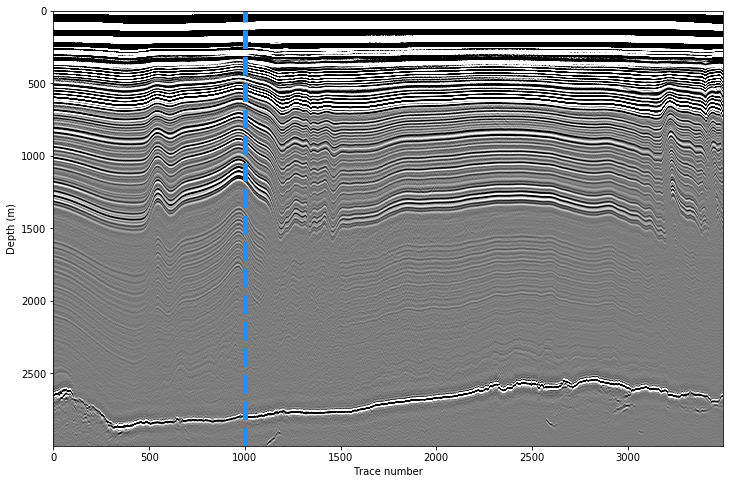

In [5]:
fig, ax = plot.plot_radargram(dat, ydat='depth')
ax.axvline(x=1000, color='dodgerblue', linewidth=5.0, linestyle='--')
plt.show()

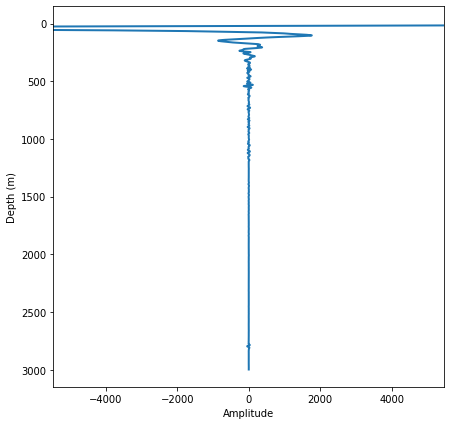

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
plot.plot_traces(dat, 1000, ydat='depth', linewidth=2.0, linestyle='solid', fig=fig, ax=ax)
plt.show()

Significant ringing at the surface (the large return at the top of the plot) is making it difficult to see what is happening deeper into the icesheet. Let's zoom in a bit. The signal is steadily decaying until about 2700m when we see a bigger return from the bedrock. To confirm this, look at the above radargram for trace 1000 and you will see this to be the case. It is important to also notice that the returned amplitude oscillates around 0, going from positive to negative, which we can use to our advantage to isolate contours at a specified returned amplitude.

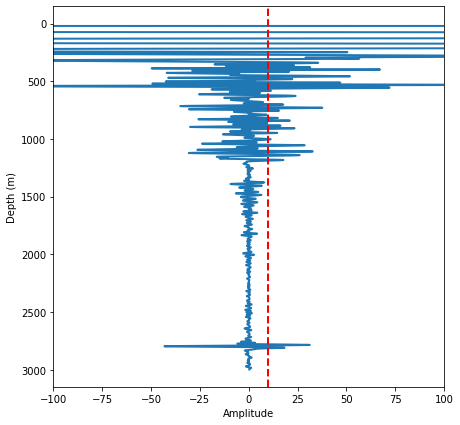

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
plot.plot_traces(dat, 1000, ydat='depth', linewidth=2.0, linestyle='solid', fig=fig, ax=ax)
ax.set_xlim(-100, 100)
ax.axvline(x=10, linestyle='--', color='r', linewidth=2.0)
plt.show()

## Isolating Contours

In the following examples, I will be using some helper functions that I wrote to process contours and find ridge/trough points in a wave packet. If you want to look more closely at how these methods work, you can find them in the `autopicker_methods.py` file accompanying this tutorial.

Now let's isolate all of the contours in a radargram. Ideally, we'd like to get as close to 0 as we could because our returned amplitude oscillates around 0. This would help us capture the most contours possible. However, this is **extremely** compute intensive. I have found good results extracting contours around some positive and negative amplitude close to 0, so that is what we will look at for the rest of this Notebook.

In [8]:
#get positive and negative contours around some amplitude
pos = find_contours(dat, 3)
neg = find_contours(dat, -3)

Each contour is a set of (x, y) points surrounding the amplitude of interest in our radargram.

In [9]:
#each contour is a set of (x,y) pairs
print(np.shape(pos[0]))

(3843, 2)


The call to `find_contours()` returns a lot of contours. We can visualize them on top of our radargram below (keeping in mind that we actually have twice as many contours since we are not plotting the negative contours, too).

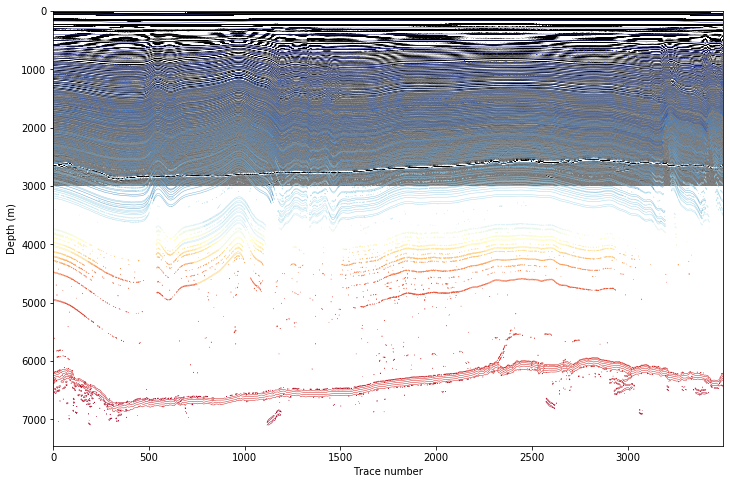

In [12]:
#### fig, ax = plt.subplots(figsize=(14, 9))
plot.plot_radargram(dat, ydat='depth')#, fig=fig, ax=ax)

#ax.set_yticks(y_ticklist)
#ax.set_yticklabels(y_ticklabels, fontsize=6)

#contours go to 7000 (yaxis), but should only go to ~ 3000
#this issue comes from the fact that dat.travel_time and dat.nmo_depth have shape ~ (7000,)
#but this is not being shown
for i, contour in enumerate(pos):
    c = cm.RdYlBu_r(i/len(pos))
    plt.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color=c)

plt.show()

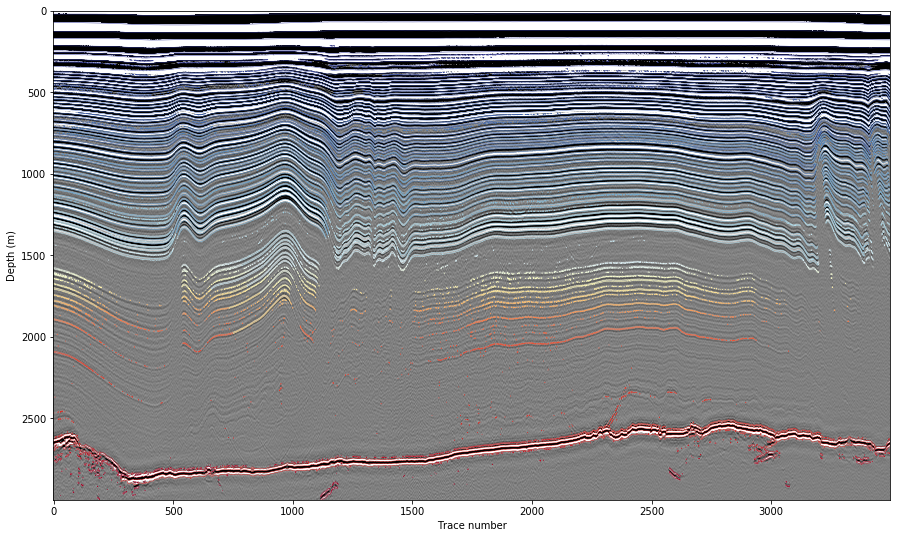

In [21]:
#colormap scaling values obtained from ImpDAR's plot function
min_ = -15
max_ = 15

#ytick list and labels
ytick_list = [0, 1184, 2367, 3551, 4734, 5917]
ytick_labels = [0, 500, 1000, 1500, 2000, 2500]

fig, ax = plt.subplots(figsize=(15, 9))
ax.imshow(dat.data, cmap='gray', aspect='auto', interpolation='nearest', vmin=min_, vmax=max_)

#iterate over contours
for i, contour in enumerate(pos):
    #change color of contours after each for loop
    #starts blue at surface, moves to yellow then red deeper in profile
    c = cm.RdYlBu_r(i/len(pos))
    
    #plot each contour on top of radargram
    plt.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color=c)

#set x and y ticks explicitly since we aren't using ImpDAR's plot_radargram() method
ax.set_yticks(ytick_list)
ax.set_yticklabels(ytick_labels)

#reset x and y labels
ax.set_xlabel('Trace number')
ax.set_ylabel('Depth (m)')

plt.show()

However, these contours are closed loops around our amplitude of interest. What we actually want is to extract the top, middle, and bottom of our wave packet so that we can calculate power over the length of our automated picks.


Some things to point out might be that we can get the bed and most of top layers, some middle layers, but because of the threshold value that we chose for choosing contours we are missing some (link to trace profile above)

**Order**:
- use helper methods to get all contours
- pretty plot contours
- then contours animation from contourMiddle_single
- then contour_troughs internal contour, all three plots
- then contour_troughs bed example
- remove find_troughs_single from helper methods file
- I don't think that I need create_internal_reflectors.py, but check to see if you can plot all contours first

## Future Work

#### Working on smoothing the contours to improve ability to pick ridges and troughs

#### Stitching together the contours so that we have continuous contours

#### Sorting Contours

Since we have the ridges, we should be able to sort them by their starting index. So for each ridge:
- we need to sort by x and y index (bubble sort?)
- https://www.geeksforgeeks.org/bubble-sort/
- https://en.wikipedia.org/wiki/Bubble_sort


- compare starting x points. is it before the previous contour?
- if no, skip
- if yes, is its y point higher? this is in an attempt to push contours closer to the upper left corner first, while pushing those towards the lower right down in the list

- maybe mention coherence metric here?

## Caveats
Here are some caveats to this method:
- For especially noisy profiles, this contouring method will not yield desirable results. This method is only as good as the processing steps that proceed it.
- That being said, this method works best for ice sheet data with planar, visibly continuous layers.
- Picks near the bed are not classified well. However, this method is not currently meant to pick the bed, but only internal reflectors. There are already a plethora of methods for picking the surface and bed of a radargram, although they are not currently implemented with this autopicking method.
- The fully automatic picker will pick contours below the bed since we are using an image processing approach: the autopicker does currently discern between what is and what isn't the bed-rock interface, it simply looks at "pixel" values.

It is my hope that this tutorial has been a sufficient walk-through of how an automatic picker using image processing methods might work so that future collaborators can either expand upon or draw from the current implementation.

## References
If you would like to read more about the efforts to create an autopicker within the radioglaciological community, here are a list of references that we have found helpful:

- Hale, D.,v2009: Structure-oriented smoothing and semblance. CWP Report 635, 10 pp., http://inside.mines.edu/~dhale/papers/Hale09StructureOrientedSmoothingAndSemblance.pdf

- Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python, PeerJ 2:e453 (2014)

- Sheriff, R. E., and L. P. Geldart, 1995: Exploration Seismology, Second Edition. Cambridge University Press, 592 pp.

- Lorensen, William and Harvey E. Cline. Marching Cubes: A High Resolution 3D Surface Construction Algorithm. Computer Graphics (SIGGRAPH 87 Proceedings) 21(4) July 1987, p. 163-170).

- Ferro, A., & Bruzzone, L. (2012). Automatic extraction and analysis of ice layering in radar sounder data. IEEE Transactions on Geoscience and Remote Sensing, 51(3), 1622-1634.

- Kamangir, H., Rahnemoonfar, M., Dobbs, D., Paden, J., & Fox, G. (2018, July). Deep hybrid wavelet network for ice boundary detection in radra imagery. In IGARSS 2018-2018 IEEE International Geoscience and Remote Sensing Symposium (pp. 3449-3452). IEEE.

- Crandall, D. J., Fox, G. C., & Paden, J. D. (2012, November). Layer-finding in radar echograms using probabilistic graphical models. In Proceedings of the 21st International Conference on Pattern Recognition (ICPR2012) (pp. 1530-1533). IEEE.

- Mitchell, J. E., Crandall, D. J., Fox, G. C., & Paden, J. D. (2013, July). A semi-automatic approach for estimating near surface internal layers from snow radar imagery. In 2013 IEEE International Geoscience and Remote Sensing Symposium-IGARSS (pp. 4110-4113). IEEE.

- Xu, M., Fan, C., Paden, J. D., Fox, G. C., & Crandall, D. J. (2018, March). Multi-task spatiotemporal neural networks for structured surface reconstruction. In 2018 IEEE Winter Conference on Applications of Computer Vision (WACV) (pp. 1273-1282). IEEE.